In [21]:
from rbf_integrator import RBFIntegrator
from sv_torch import SineGordonIntegrator
import numpy as np

In [2]:
L = 8
Lx_min = Ly_min = -L
Lx_max = Ly_max =  L
nt = 500
nx = ny = 36
T = final_T = 10.

In [6]:
# two different solvers as this is not yet nicely engineered
solver1 = SineGordonIntegrator(Lx_min, Lx_max, Ly_min, Ly_max, T, nt, nx, ny, device='cpu')
solver2 = SineGordonIntegrator(Lx_min, Lx_max, Ly_min, Ly_max, T, nt, nx, ny, device='cpu')
# RBF solver is in separate object
solver3 = RBFIntegrator(Lx_min, Lx_max, Ly_min, Ly_max, nt, T)

In [7]:
solver1.evolve()
solver2.evolve_ETD1()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:02<00:00, 172.20it/s]


In [8]:
solver3.evolve()

In [25]:
X, Y = solver1.X.cpu().numpy(), solver1.Y.cpu().numpy() 
data1 = solver1.u.cpu().numpy()
data2 = solver2.u.cpu().numpy()
un1, vn1 = [data1[0]], [np.zeros_like(data1[0])]
un2, vn2 = [data2[0]], [np.zeros_like(data2[0])]
dt = T / nt
for i in range(1, nt):
    # simple first order approximate for velocity as we don't actually need velocity to evolve
    un1.append(data1[i])
    vn1.append((data1[i] - data1[i-1]) / dt)
    un2.append(data2[i])
    vn2.append((data2[i] - data2[i-1]) / dt)
un1, vn1 = np.array(un1), np.array(vn1)
un2, vn2 = np.array(un2), np.array(vn2)

rbf_x, rbf_y, un3, vn3 = solver3.get_solution()

In [26]:
import numpy as np
def calculate_energy(u, v, nx, ny, dx, dy):
    ux = (u[1:-1, 2:] - u[1:-1, :-2]) / (2. * dx)
    uy = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2. * dy)
    ut = v[1:-1, 1:-1]
    ux2 = ux ** 2
    uy2 = uy ** 2
    ut2 = ut ** 2
    cos = 2 * (1 - np.cos(u[1:-1, 1:-1]))
    integrand = np.sum(ux2 + uy2 + ut2 + cos)
    # simple trapeziodal rule
    return 0.5 * integrand * dx * dy

def topological_charge(u, dx):
    u_x = np.zeros_like(u)
    u_x[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dx)
    topological_charge = (1 / (2 * np.pi)) * u_x[:, 1] * dx
    return np.sum(topological_charge)

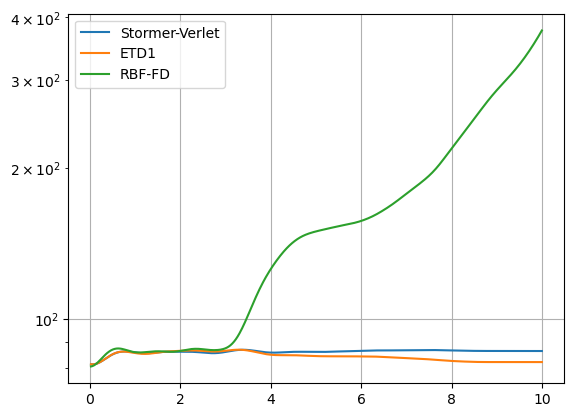

In [39]:
def energy_over_time(un, vn, Lx_min, Lx_max, Ly_min, Ly_max, tn, nx, ny):
    es = []
    dx = (Lx_max - Lx_min) / (nx - 1)
    dy = (Ly_max - Ly_min) / (ny - 1)
    for i in range(1, tn.shape[0]):
        u, v = un[i], vn[i]
        es.append(calculate_energy(u, v, nx, ny, dx, dy))
    return np.array(es)

e1 = energy_over_time(un1, vn1, Lx_min, Lx_max, Ly_min, Ly_max, solver1.tn, solver1.nx, solver1.ny)
e2 = energy_over_time(un2, vn2, Lx_min, Lx_max, Ly_min, Ly_max, solver2.tn, solver2.nx, solver2.ny)
e3 = energy_over_time(un3, vn3, Lx_min, Lx_max, Ly_min, Ly_max, solver1.tn, nx, ny)

import matplotlib.pyplot as plt
names = ["Stormer-Verlet", "ETD1", "RBF-FD"]
for i, e in enumerate([e1, e2, e3]):
    plt.plot(solver1.tn[1:], e, label=names[i])
plt.grid(True)
plt.legend()
plt.yscale("log")

plt.show()


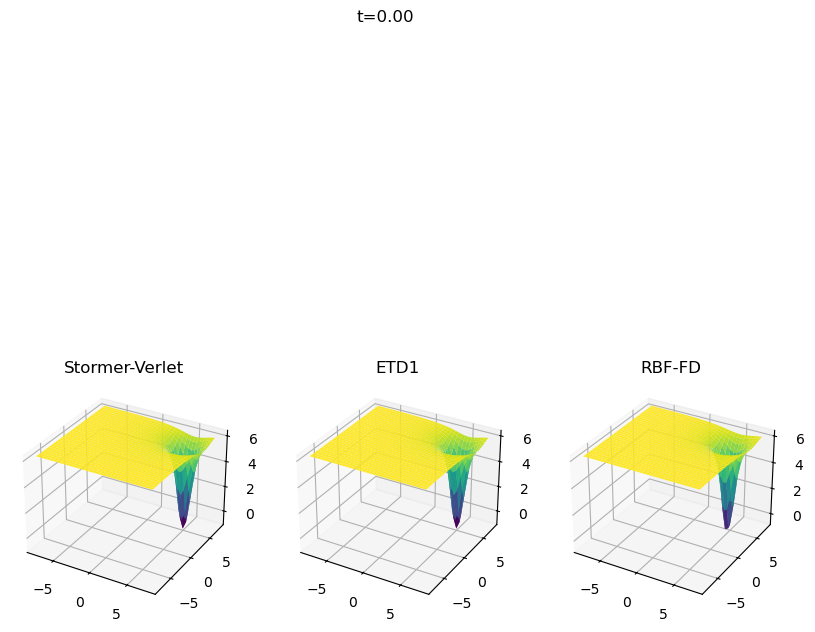

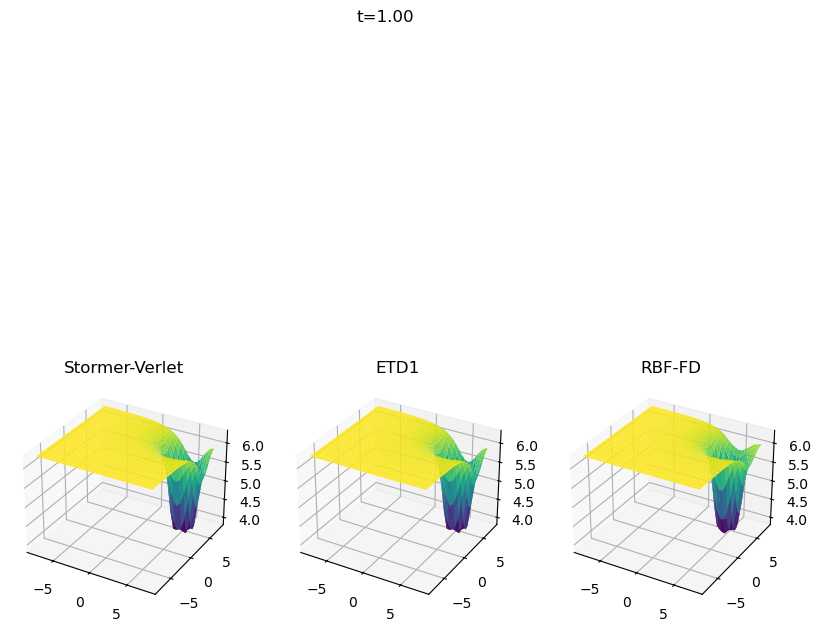

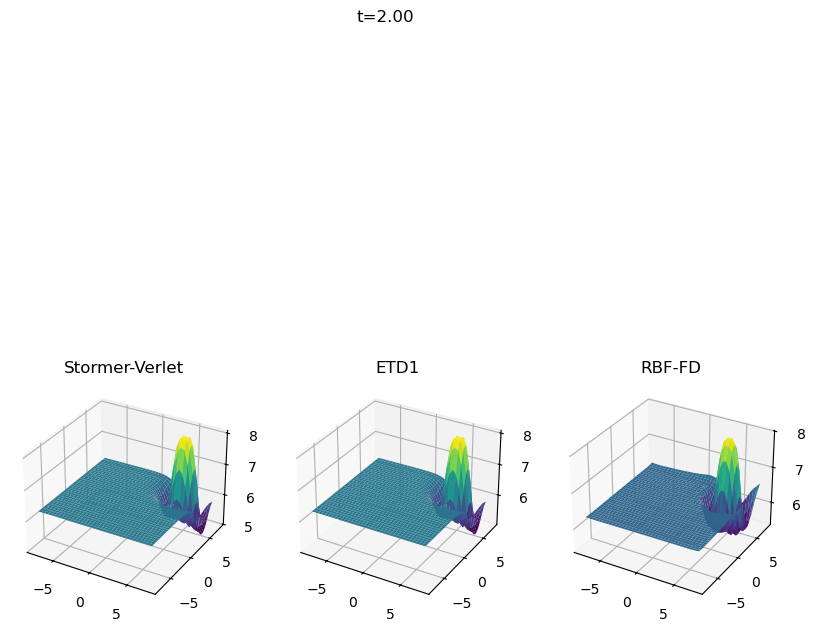

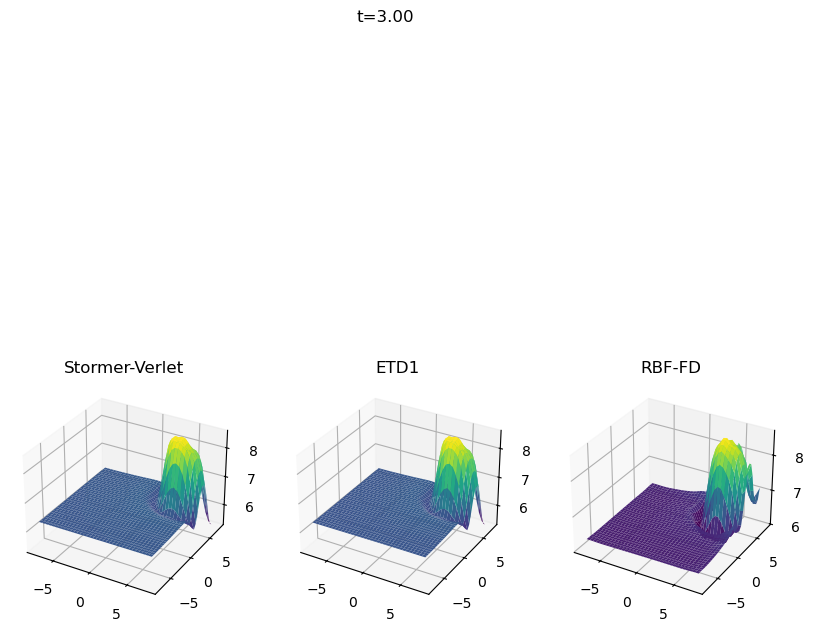

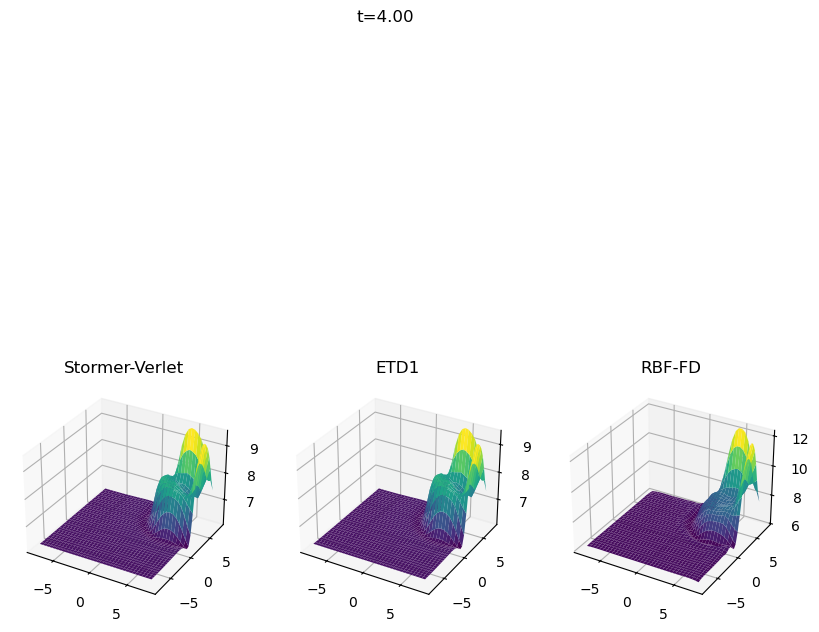

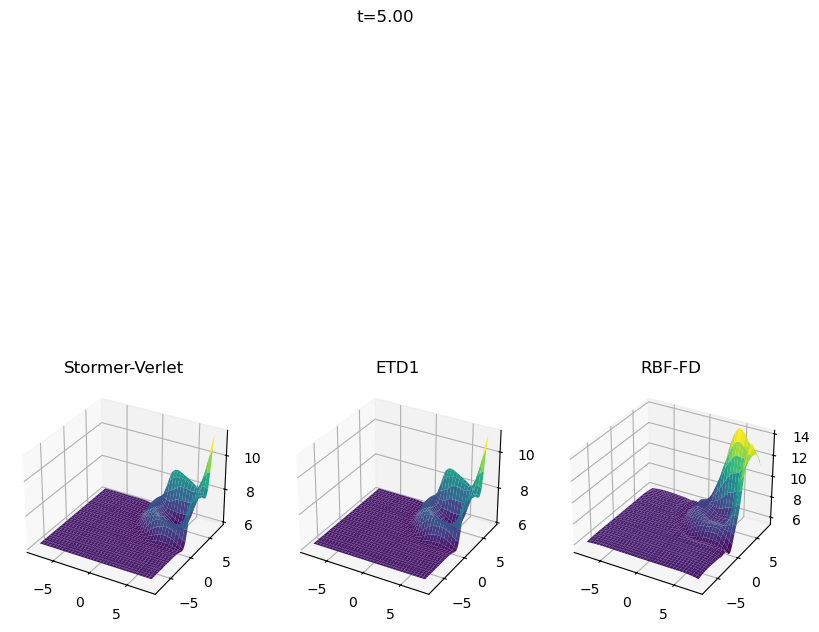

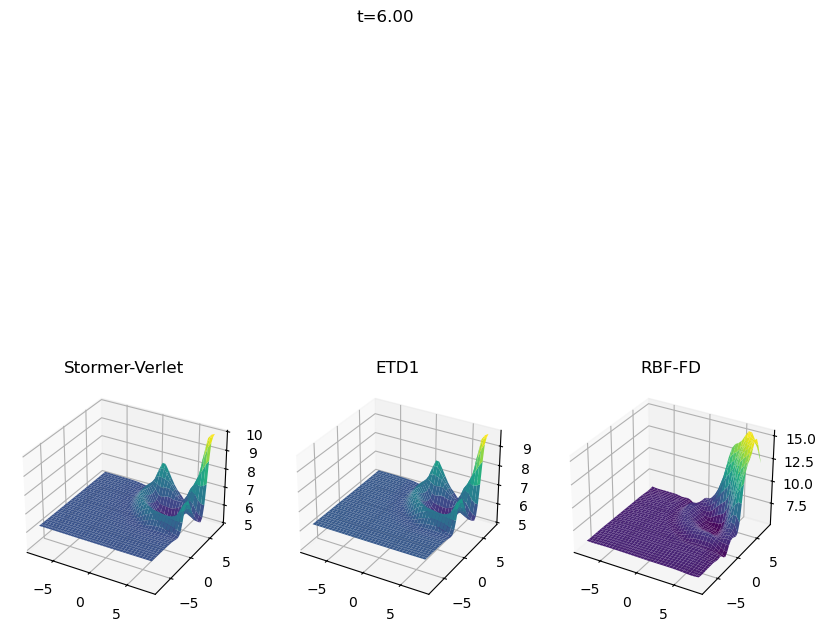

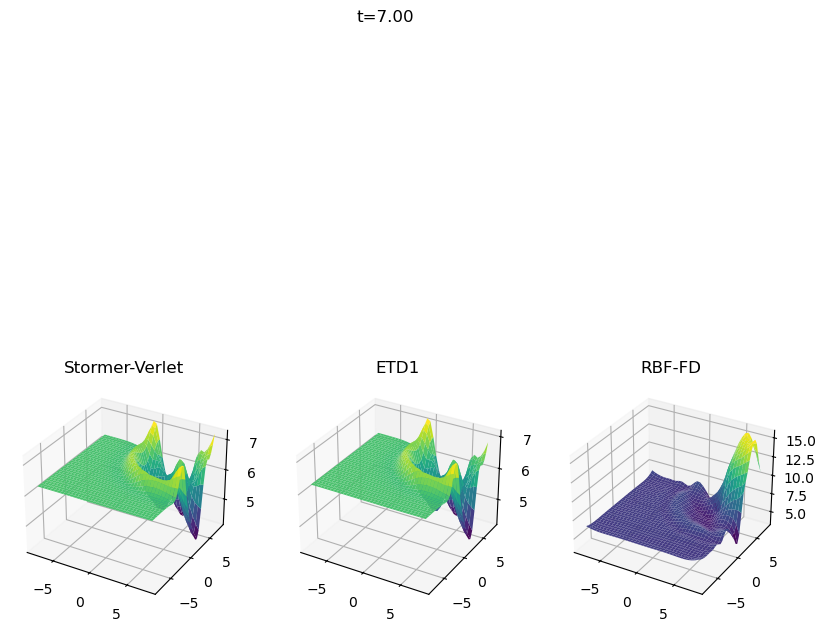

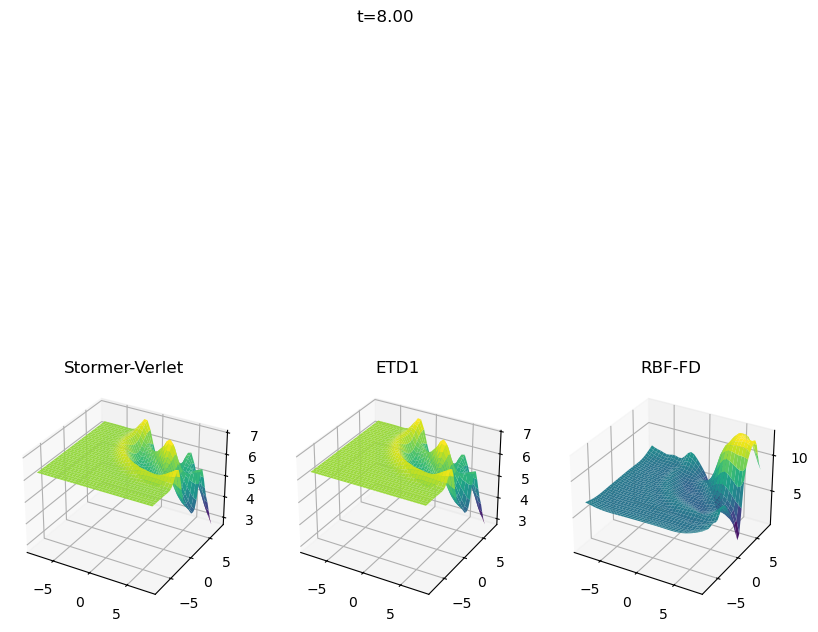

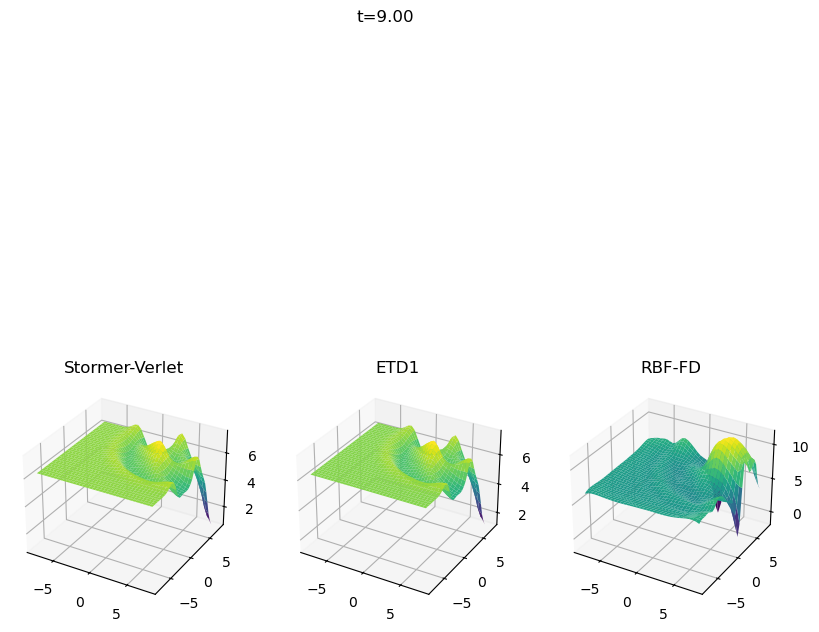

In [42]:
#axs[i]plot_surface(solver.X[1:-1, 1:-1], solver.Y[1:-1, 1:-1]

for t in np.linspace(0, 9, 10):
    fig, axs = plt.subplots(figsize=(10, 10), ncols=3, subplot_kw={"projection":'3d'})
    ti = int(t / dt)
    axs[0].plot_surface(solver1.X[1:-1, 1:-1],solver1.Y[1:-1, 1:-1], un1[ti].reshape((nx+2, ny+2))[1:-1, 1:-1], cmap='viridis')
    axs[1].plot_surface(solver1.X[1:-1, 1:-1],solver1.Y[1:-1, 1:-1], un2[ti].reshape((nx+2, ny+2))[1:-1, 1:-1], cmap='viridis')
    axs[2].plot_surface(solver1.X[1:-1, 1:-1],solver1.Y[1:-1, 1:-1], un3[ti].reshape((nx, ny)), cmap='viridis')
    fig.suptitle(f"{t=:.2f}")
    for i in range(3):
        axs[i].set_title(names[i])
    
    